In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import seaborn as sns
import pickle
import collections

In [2]:
## loading the data

data=pd.read_pickle('stage_2_toc_s2_data.pkl')

data.head()

WELL  PEFWS     GRWS  DENWS    DTWS  DRESWS Interval  \
11008.0  ANASAZI `16` STATE 1  2.865  103.895  2.594  68.471  15.191     WC A   
11008.5  ANASAZI `16` STATE 1  2.809   98.146  2.595  67.866  14.876     WC A   
11009.0  ANASAZI `16` STATE 1  2.764   93.175  2.598  67.542  14.776     WC A   
11009.5  ANASAZI `16` STATE 1  2.820   87.963  2.601  67.714  15.113     WC A   
11010.0  ANASAZI `16` STATE 1  2.938   86.100  2.597  68.097  15.504     WC A   

         facies_km  facies_hc  facies_sc        S2       TOC       LOM  \
11008.0          0          1          1  2.585085  1.319427  9.847191   
11008.5          0          1          1  2.405933  1.227988  9.847191   
11009.0          0          1          1  2.326419  1.187404  9.847191   
11009.5          0          1          1  2.438252  1.244483  9.847191   
11010.0          0          1          1  2.596725  1.325368  9.847191   

            dlogR  
11008.0  0.305908  
11008.5  0.284708  
11009.0  0.275299  
11009.5  0.288533  
11010.0  0.307286

In [3]:
len(data) ## only wolfcamp A

14439

In [4]:
np.unique(data['facies_km'], return_counts=True)

(array([0, 1, 2]), array([5718, 5344, 3377], dtype=int64))

In [6]:
### isolating shale for second level clustering

## facies 1 from kmeans was interpreted to be shale

df_shale=data.loc[data['facies_km']==1] ## shale is facies 1 in Wolfcamp A clustering
df_shale

WELL  PEFWS     GRWS  DENWS    DTWS  DRESWS  \
11032.0   ANASAZI `16` STATE 1  3.126  121.460  2.559  71.500  27.214   
11032.5   ANASAZI `16` STATE 1  3.133  129.964  2.559  71.500  27.328   
11033.0   ANASAZI `16` STATE 1  3.083  125.979  2.564  70.897  27.443   
11035.5   ANASAZI `16` STATE 1  2.880  122.580  2.561  70.167  31.931   
11036.0   ANASAZI `16` STATE 1  2.867  121.702  2.551  70.799  31.931   
...                        ...    ...      ...    ...     ...     ...   
8785.5   WHITE CITY UNIT COM 2  3.743  116.898  2.603  85.066   6.199   
8786.0   WHITE CITY UNIT COM 2  3.861  114.825  2.608  84.000   6.509   
8795.5   WHITE CITY UNIT COM 2  3.723  114.131  2.617  83.369   6.268   
8796.0   WHITE CITY UNIT COM 2  3.697  113.658  2.611  84.140   6.131   
8796.5   WHITE CITY UNIT COM 2  3.661  113.032  2.610  84.492   6.037   

        Interval  facies_km  facies_hc  facies_sc        S2       TOC  \
11032.0     WC A          1          1          1  5.236741  2.672832   
11032.5     WC A          1          1          1  5.252083  2.680662   
11033.0     WC A          1          1          1  5.165581  2.636512   
11035.5     WC A          1          1          1  5.598087  2.857263   
11036.0     WC A          1          1          1  5.704902  2.911781   
...          ...        ...        ...        ...       ...       ...   
8785.5      WC A          1          1          1  1.737172  0.959949   
8786.0      WC A          1          1          1  1.736282  0.959457   
8795.5      WC A          1          1          1  1.533552  0.847430   
8796.0      WC A          1          1          1  1.574247  0.869917   
8796.5      WC A          1          1          1  1.576552  0.871191   

               LOM     dlogR  
11032.0   9.847191  0.619694  
11032.5   9.847191  0.621510  
11033.0   9.847191  0.611274  
11035.5   9.847191  0.662454  
11036.0   9.847191  0.675094  
...            ...       ...  
8785.5   10.131248  0.248544  
8786.0   10.131248  0.248416  
8795.5   10.131248  0.219411  
8796.0   10.131248  0.225233  
8796.5   10.131248  0.225563  

[5344 rows x 14 columns]

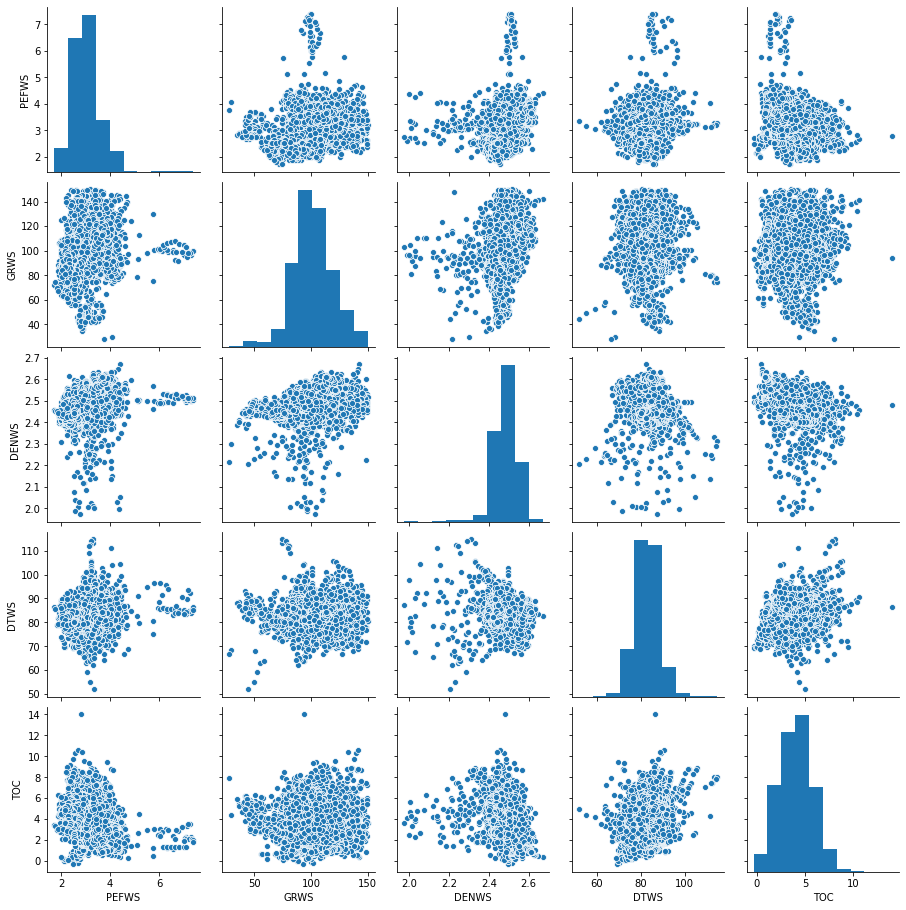

In [9]:
## visualizing the unscaled data

labelled_dataframe = pd.DataFrame(data = df_shale, columns = ['PEFWS', 'GRWS', 'DENWS', 'DTWS', 'TOC'])
sns.pairplot(labelled_dataframe) # Create a matrix scatterplot

In [10]:
## logs vary a lot in scales, so we use standardscaler 

from sklearn.preprocessing import RobustScaler
scale=RobustScaler()
x_scaled=scale.fit_transform(df_shale[['PEFWS', 'GRWS', 'DENWS', 'DTWS','TOC',]])


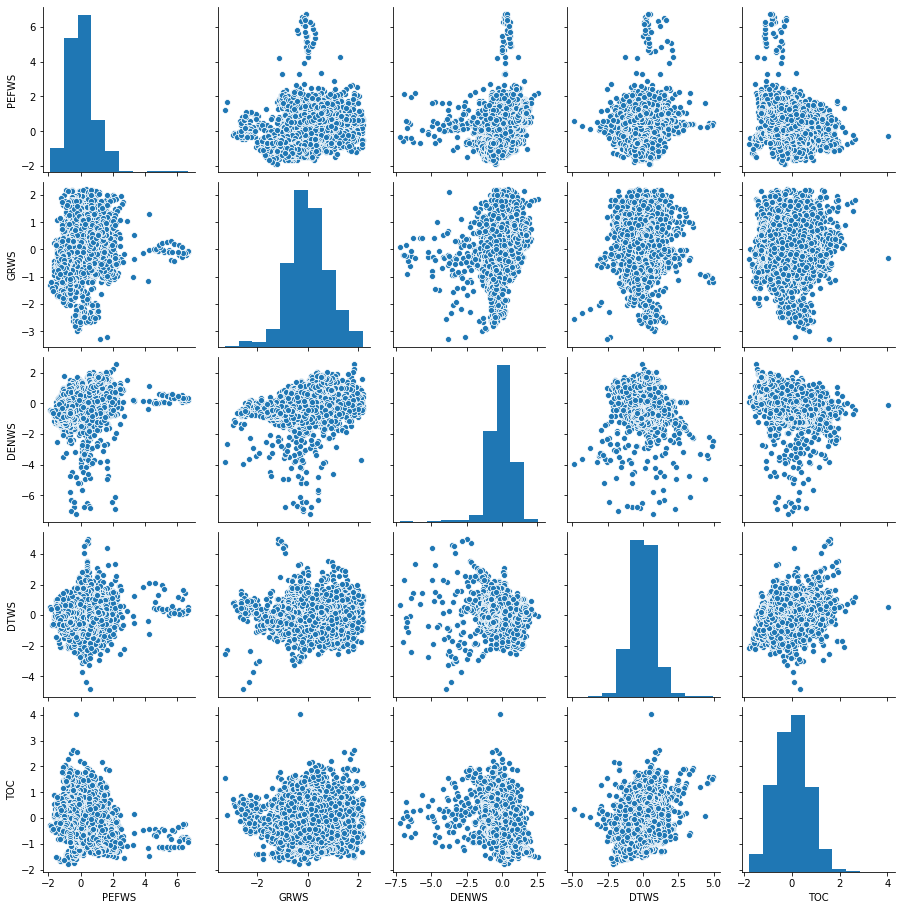

In [11]:
labelled_dataframe = pd.DataFrame(data = x_scaled, columns = ['PEFWS', 'GRWS', 'DENWS', 'DTWS', 'TOC'])
sns.pairplot(labelled_dataframe) # Create a matrix scatterplot

### finding numer of clusters present in the data

Text(0, 0.5, 'Within-cluster Sum of Squares')

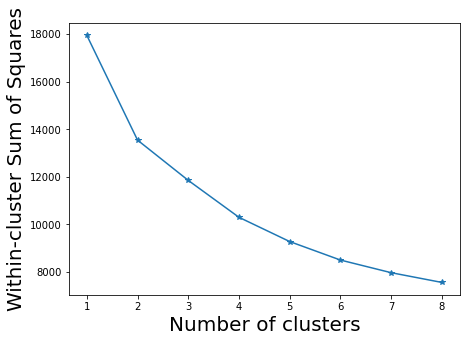

In [18]:
## Method 1: elbow curve

wcss = []  # Store within sum of square values for each cluster size
cl_num = 9 # Total number of clusters
for i in range (1,cl_num):
    kmeans = KMeans(i, random_state=10) 
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_ # calculates the wcss
    wcss.append(wcss_iter)
    
number_clusters = range(1,cl_num)
plt.figure(figsize=(7,5))
plt.plot(number_clusters, wcss, '*-')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Within-cluster Sum of Squares',fontsize=20)

In [17]:
## method 2: silhoutte score..the higher the better

from sklearn.metrics import silhouette_score
range_n_clusters = [2,3,4,5,6,7] # Number of clusters
for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_scaled)
    
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.24558631233346429
For n_clusters = 3 The average silhouette_score is : 0.2390211554342672
For n_clusters = 4 The average silhouette_score is : 0.21862789932822108
For n_clusters = 5 The average silhouette_score is : 0.22352042896354413
For n_clusters = 6 The average silhouette_score is : 0.19669243871115438
For n_clusters = 7 The average silhouette_score is : 0.19475152404165127


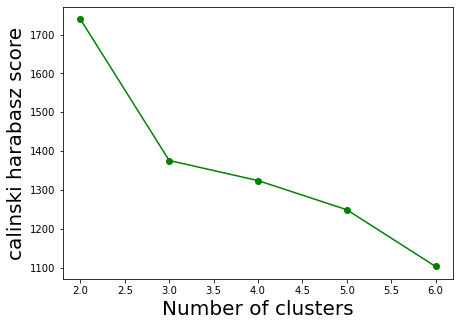

In [14]:
## method 4: calinski_harabasz_score...the higher, the better

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

num_clusters=[]
ch_score=[]

for k in range(2, 7):
    num_clusters.append(k)
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(x_scaled)
    labels = kmeans_model.labels_
    ch_score.append(calinski_harabasz_score(x_scaled, labels))
    

plt.figure(figsize=(7,5))
plt.plot(num_clusters, ch_score, '-o', color='green')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('calinski harabasz score',fontsize=20)
plt.show()

Text(0, 0.5, 'davies bouldin score')

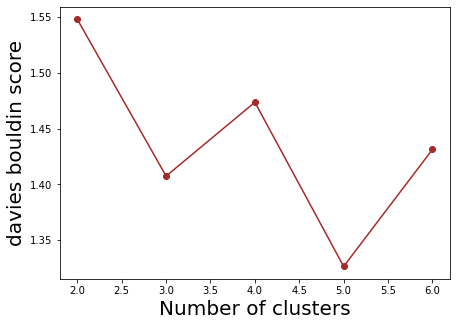

In [15]:
## method 5: davies boulding score..the closer to 0, the better

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score 

num_clusters=[]
db_score=[]

for k in range(2, 7):
    num_clusters.append(k)
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(x_scaled)
    labels = kmeans_model.labels_
    db_score.append(davies_bouldin_score(x_scaled, labels))
    

plt.figure(figsize=(7,5))
plt.plot(num_clusters, db_score, '-o', color='brown')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('davies bouldin score',fontsize=20)

In [16]:
db_score

[1.548070578317181,
 1.40743687624113,
 1.4736789826809282,
 1.326376050557613,
 1.4313062789567637]

## clustering using kmeans and spectral

In [19]:
## clustering using kmeans

n_clusters=3
km=KMeans(n_clusters=n_clusters, n_init=10, random_state=10)
km.fit(x_scaled)

KMeans(n_clusters=3, random_state=10)

In [20]:
collections.Counter(km.labels_)

Counter({2: 1924, 0: 2810, 1: 610})

In [21]:
sil_score=metrics.silhouette_score(x_scaled, km.labels_, metric='euclidean')
ch_score=metrics.calinski_harabasz_score(x_scaled, km.labels_)
db_score=metrics.davies_bouldin_score(x_scaled, km.labels_)
print(sil_score, ch_score, db_score)

0.2390211554342672 1375.5846516943943 1.40743687624113


In [22]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, n_init=20, affinity='nearest_neighbors', n_neighbors=10,
             assign_labels="discretize",
             random_state=0).fit(x_scaled)

In [23]:
sil_score=metrics.silhouette_score(x_scaled, sc.labels_, metric='euclidean')
ch_score=metrics.calinski_harabasz_score(x_scaled, sc.labels_)
db_score=metrics.davies_bouldin_score(x_scaled, sc.labels_)
print(sil_score, ch_score, db_score)

0.2447861043637667 1228.303228869 1.3428928567056646


In [24]:
metrics.adjusted_rand_score(km.labels_, sc.labels_)

0.6624919653482447

In [25]:
df_shale['facies_km']=km.labels_
#data['facies_sc']=sc.labels_

D:\Programs\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


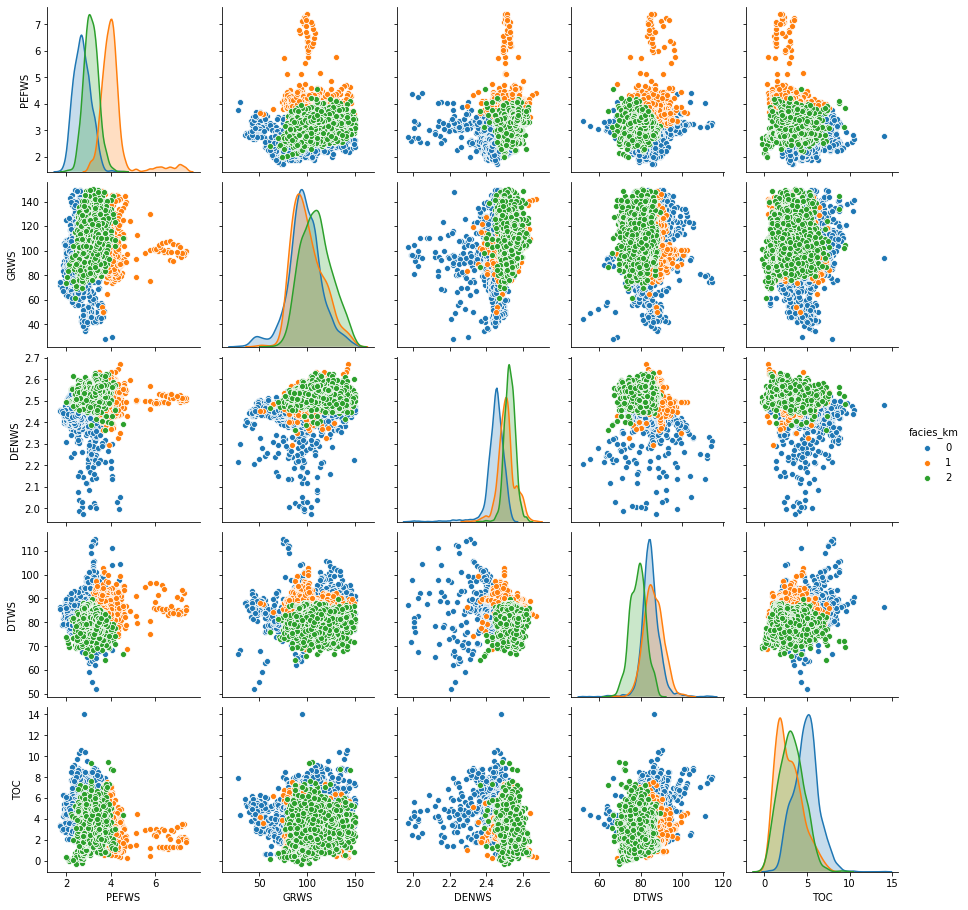

In [26]:
sns.pairplot(df_shale[['PEFWS', 'GRWS', 'DENWS', 'DTWS', 'TOC', 'facies_km']], hue='facies_km')

In [27]:
## giving different labels to the facies....3, 4, 5 instead of 0, 1, 2

df_shale['facies_km'].loc[df_shale['facies_km']==0]=3

D:\Programs\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
D:\Programs\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
df_shale['facies_km'].loc[df_shale['facies_km']==1]=4
df_shale['facies_km'].loc[df_shale['facies_km']==2]=5

D:\Programs\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programs\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
data ## first level clusters

WELL  PEFWS     GRWS  DENWS    DTWS  DRESWS  \
11008.0   ANASAZI `16` STATE 1  2.865  103.895  2.594  68.471  15.191   
11008.5   ANASAZI `16` STATE 1  2.809   98.146  2.595  67.866  14.876   
11009.0   ANASAZI `16` STATE 1  2.764   93.175  2.598  67.542  14.776   
11009.5   ANASAZI `16` STATE 1  2.820   87.963  2.601  67.714  15.113   
11010.0   ANASAZI `16` STATE 1  2.938   86.100  2.597  68.097  15.504   
...                        ...    ...      ...    ...     ...     ...   
8794.5   WHITE CITY UNIT COM 2  3.796  108.610  2.622  82.344   6.037   
8795.0   WHITE CITY UNIT COM 2  3.753  112.532  2.622  82.870   6.225   
8795.5   WHITE CITY UNIT COM 2  3.723  114.131  2.617  83.369   6.268   
8796.0   WHITE CITY UNIT COM 2  3.697  113.658  2.611  84.140   6.131   
8796.5   WHITE CITY UNIT COM 2  3.661  113.032  2.610  84.492   6.037   

        Interval  facies_km  facies_hc  facies_sc        S2       TOC  \
11008.0     WC A          0          1          1  2.585085  1.319427   
11008.5     WC A          0          1          1  2.405933  1.227988   
11009.0     WC A          0          1          1  2.326419  1.187404   
11009.5     WC A          0          1          1  2.438252  1.244483   
11010.0     WC A          0          1          1  2.596725  1.325368   
...          ...        ...        ...        ...       ...       ...   
8794.5      WC A          0          1          1  1.276287  0.705267   
8795.0      WC A          0          1          1  1.442902  0.797337   
8795.5      WC A          1          1          1  1.533552  0.847430   
8796.0      WC A          1          1          1  1.574247  0.869917   
8796.5      WC A          1          1          1  1.576552  0.871191   

               LOM     dlogR  
11008.0   9.847191  0.305908  
11008.5   9.847191  0.284708  
11009.0   9.847191  0.275299  
11009.5   9.847191  0.288533  
11010.0   9.847191  0.307286  
...            ...       ...  
8794.5   10.131248  0.182603  
8795.0   10.131248  0.206441  
8795.5   10.131248  0.219411  
8796.0   10.131248  0.225233  
8796.5   10.131248  0.225563  

[14439 rows x 14 columns]

In [30]:
df_shale   ## second level clusters in shale data

WELL  PEFWS     GRWS  DENWS    DTWS  DRESWS  \
11032.0   ANASAZI `16` STATE 1  3.126  121.460  2.559  71.500  27.214   
11032.5   ANASAZI `16` STATE 1  3.133  129.964  2.559  71.500  27.328   
11033.0   ANASAZI `16` STATE 1  3.083  125.979  2.564  70.897  27.443   
11035.5   ANASAZI `16` STATE 1  2.880  122.580  2.561  70.167  31.931   
11036.0   ANASAZI `16` STATE 1  2.867  121.702  2.551  70.799  31.931   
...                        ...    ...      ...    ...     ...     ...   
8785.5   WHITE CITY UNIT COM 2  3.743  116.898  2.603  85.066   6.199   
8786.0   WHITE CITY UNIT COM 2  3.861  114.825  2.608  84.000   6.509   
8795.5   WHITE CITY UNIT COM 2  3.723  114.131  2.617  83.369   6.268   
8796.0   WHITE CITY UNIT COM 2  3.697  113.658  2.611  84.140   6.131   
8796.5   WHITE CITY UNIT COM 2  3.661  113.032  2.610  84.492   6.037   

        Interval  facies_km  facies_hc  facies_sc        S2       TOC  \
11032.0     WC A          5          1          1  5.236741  2.672832   
11032.5     WC A          5          1          1  5.252083  2.680662   
11033.0     WC A          5          1          1  5.165581  2.636512   
11035.5     WC A          5          1          1  5.598087  2.857263   
11036.0     WC A          5          1          1  5.704902  2.911781   
...          ...        ...        ...        ...       ...       ...   
8785.5      WC A          4          1          1  1.737172  0.959949   
8786.0      WC A          4          1          1  1.736282  0.959457   
8795.5      WC A          5          1          1  1.533552  0.847430   
8796.0      WC A          4          1          1  1.574247  0.869917   
8796.5      WC A          4          1          1  1.576552  0.871191   

               LOM     dlogR  
11032.0   9.847191  0.619694  
11032.5   9.847191  0.621510  
11033.0   9.847191  0.611274  
11035.5   9.847191  0.662454  
11036.0   9.847191  0.675094  
...            ...       ...  
8785.5   10.131248  0.248544  
8786.0   10.131248  0.248416  
8795.5   10.131248  0.219411  
8796.0   10.131248  0.225233  
8796.5   10.131248  0.225563  

[5344 rows x 14 columns]

In [32]:
df_shale=df_shale.drop(['facies_hc', 'facies_sc'], axis=1)
np.unique(df_shale['facies_km'])

array([3, 4, 5])

In [33]:
data['facies_km'].loc[data['facies_km']==1]=df_shale['facies_km'] ## replacing shale in original data with sub clusters

D:\Programs\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
np.unique(data[['facies_km']], return_counts=True)

(array([0, 2, 3, 4, 5]), array([5718, 3377, 2810,  610, 1924], dtype=int64))

In [35]:
## saving the combined data with 1st and 2nd level facies

data.to_pickle('stage_2_combined_clusters_TOC_WCA.pkl')

In [44]:
## visulaizing the logs alongside the facies labels

from matplotlib import colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
facies_colors = ['#ffff00','#000000','#999966','#996633','#cc9900']

def make_facies_log_plot(data, well_name, label1):
    logs=data.loc[(data['WELL']==well_name)]
    #make sure logs are sorted by depth
    #logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    #color_dict={0:'red', 1:'blue', 2:'green', 4:'yellow'}
    
    ztop=logs.index.min(); zbot=logs.index.max()
    
    cluster1=np.repeat(np.expand_dims(logs[label1].values,1), 100, 1)
    
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 17))
    ax[0].plot(logs.DTWS, logs.index, '-g', linewidth=3)
    ax[1].plot(logs.GRWS, logs.index, '-', linewidth=3)
    ax[2].plot(logs.PEFWS, logs.index, '-', linewidth=3, color='0.5')
    ax[3].plot(logs.DENWS, logs.index, '-', linewidth=3, color='r')
    ax[4].plot(logs.TOC, logs.index, color='black', linewidth =3)
    #ax[4].xaxis.label.set_color("black")
    #ax[4].tick_params(axis='x', colors="black")
    #ax[4].spines["top"].set_edgecolor("black")
    
    #im=ax[4].imshow(logs[label].values.reshape(len(logs),1),cmap=cmap_facies, interpolation='none',
    #                aspect='auto',vmin=0,vmax=3)
    
    im1=ax[5].imshow(cluster1,cmap=cmap_facies, interpolation='none',
                    aspect='auto',vmin=0,vmax=6)
    
    
    divider1 = make_axes_locatable(ax[5])
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
   
    
    cbar=plt.colorbar(im1, cax=cax1)
    cbar.set_label((35*' ').join(['0', '2', '3', '4', '5']),fontsize=16)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    #for key in color_dict.keys():
    #    ax[4].fill_betweenx(logs.index, 0, logs.facies_km, where=(data['facies_km']==key),facecolor=color_dict[key])
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        #ax[i].set_ylim(10000,15500)
        ax[i].invert_yaxis()
        ax[i].grid(linewidth=1.2, c='black')
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].tick_params(which='both', labelsize=14)
    
    ax[0].set_xlabel("DTWS",fontsize=16)
    ax[0].set_xlim(logs.DTWS.min(),logs.DTWS.max())
    ax[1].set_xlabel("GRWS",fontsize=16)
    ax[1].set_xlim(logs.GRWS.min(),logs.GRWS.max())
    ax[2].set_xlabel("PEFWS",fontsize=16)
    ax[2].set_xlim(logs.PEFWS.min(),logs.PEFWS.max())
    ax[3].set_xlabel("DENWS",fontsize=16)
    ax[3].set_xlim(logs.DENWS.min(),logs.DENWS.max())
    ax[4].set_xlabel("TOC",fontsize=16)
    ax[4].set_xlim(logs.TOC.min(),logs.TOC.max())
    ax[5].set_xlabel('%s'%label1,fontsize=16)
    
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[4].set_yticklabels([])
    #ax[1].set_ylim(np.arange(min(logs.index), max(logs.index), step=200))
    ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    
    f.suptitle('Well: %s'%well_name, fontsize=20,y=0.94)

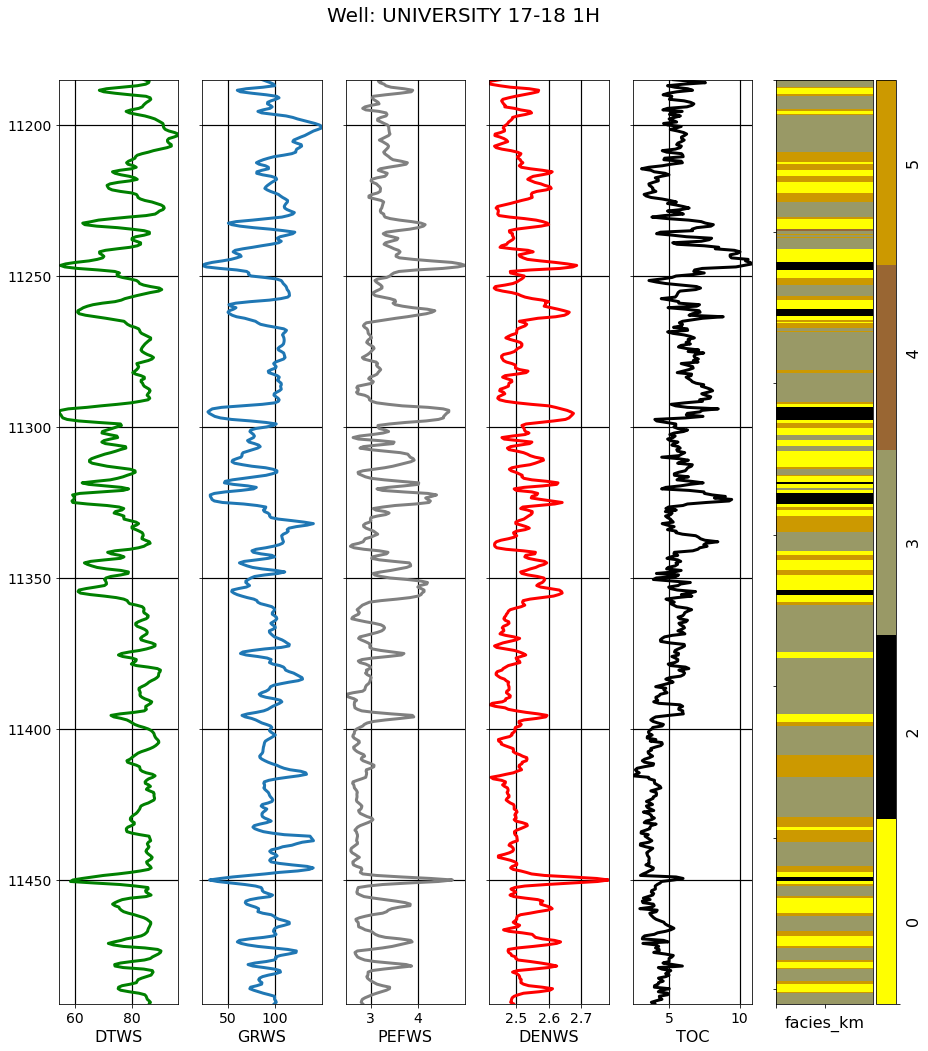

In [45]:
make_facies_log_plot(data, 'UNIVERSITY 17-18 1H', 'facies_km')

D:\Programs\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
D:\Programs\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
D:\Programs\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
D:\Programs\lib\site-pack

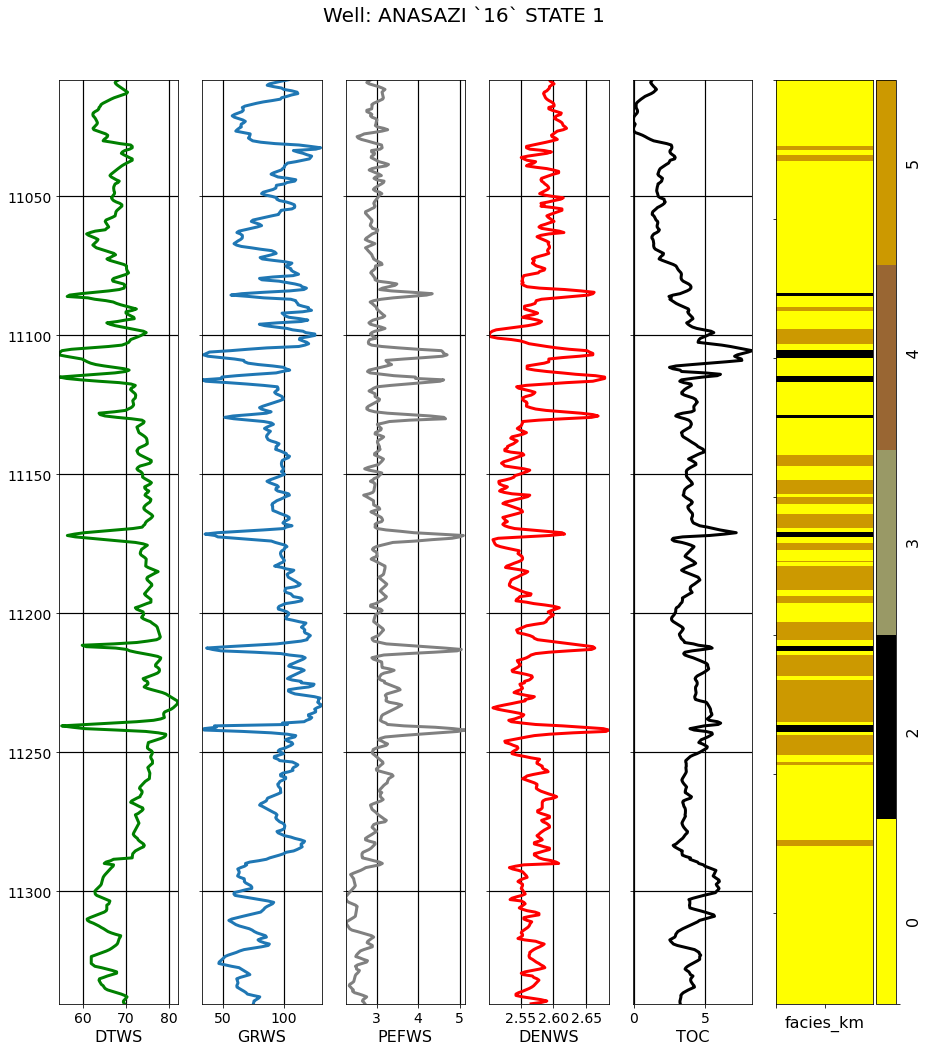

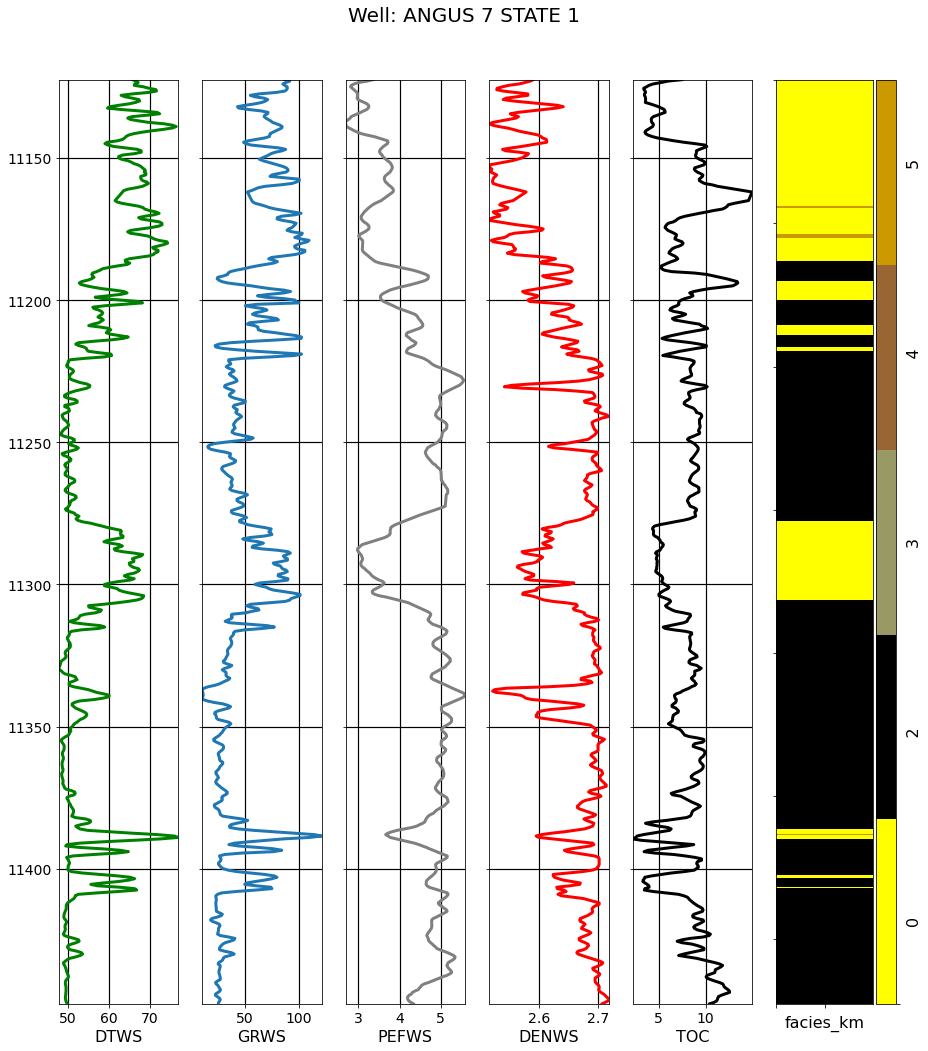

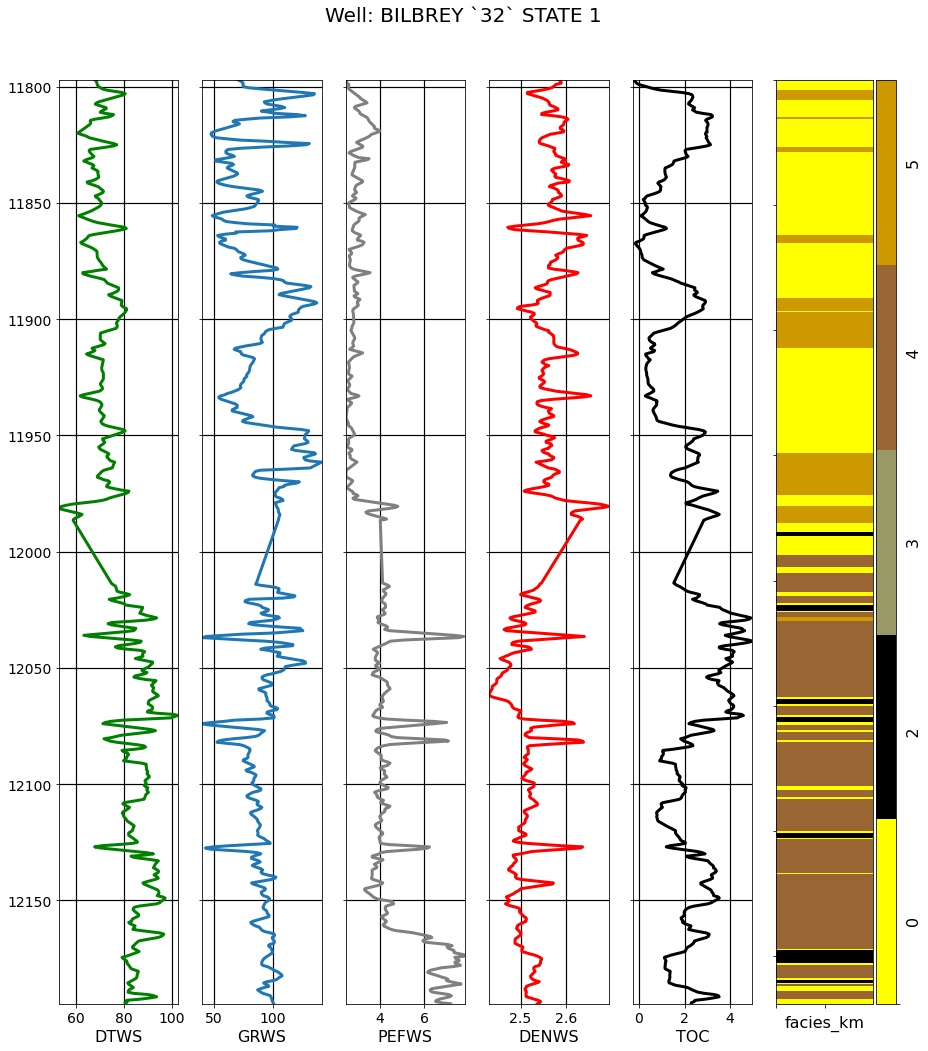

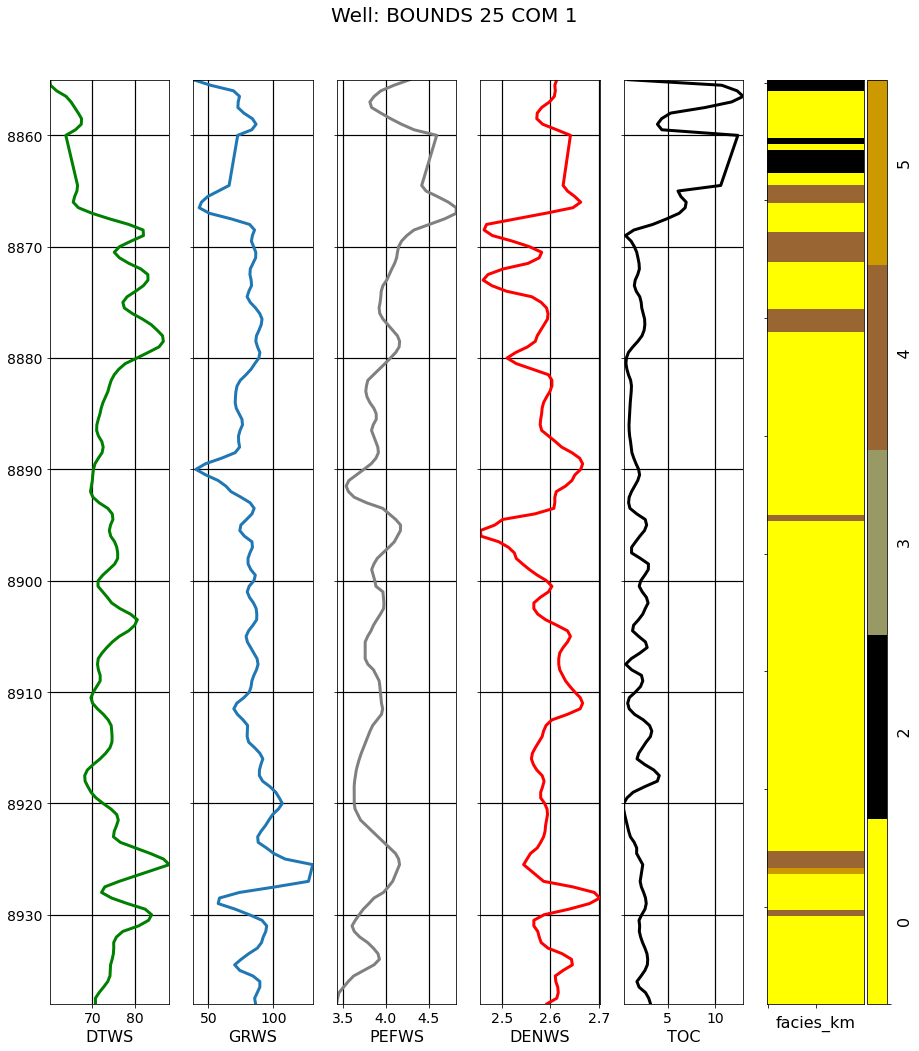

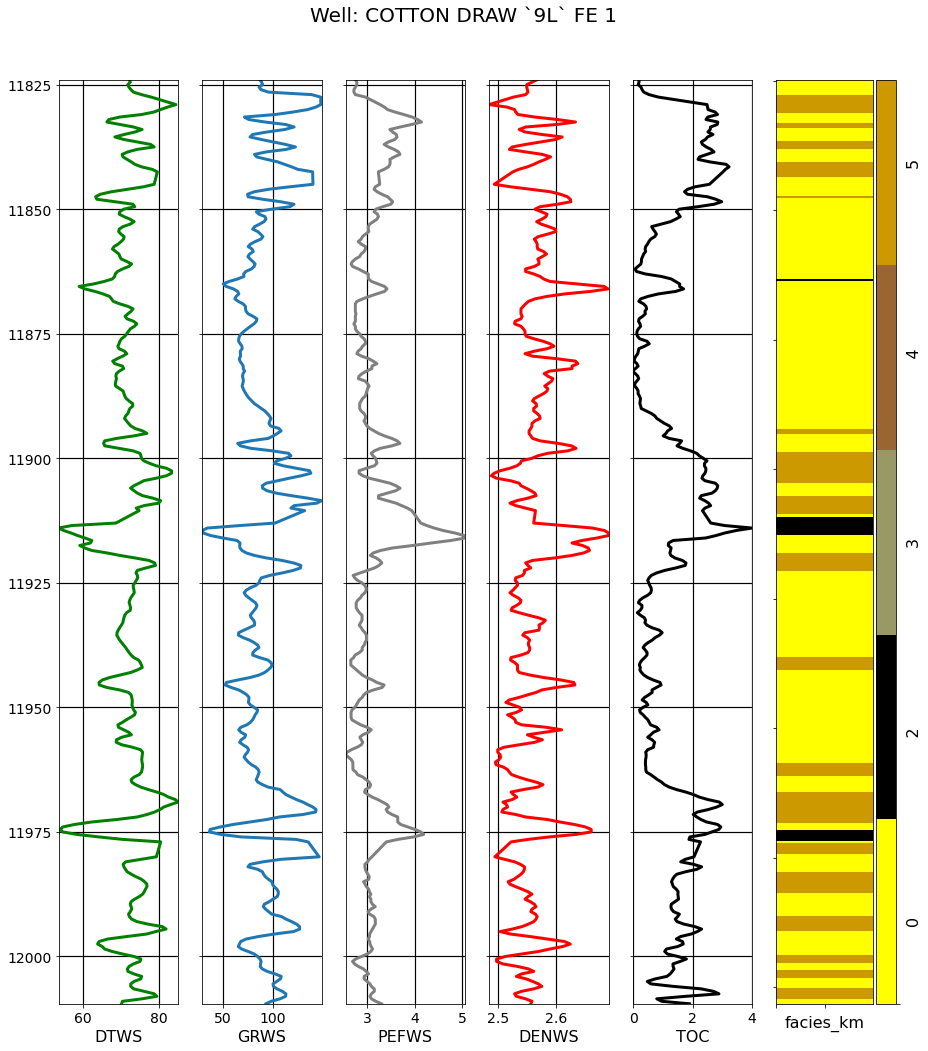

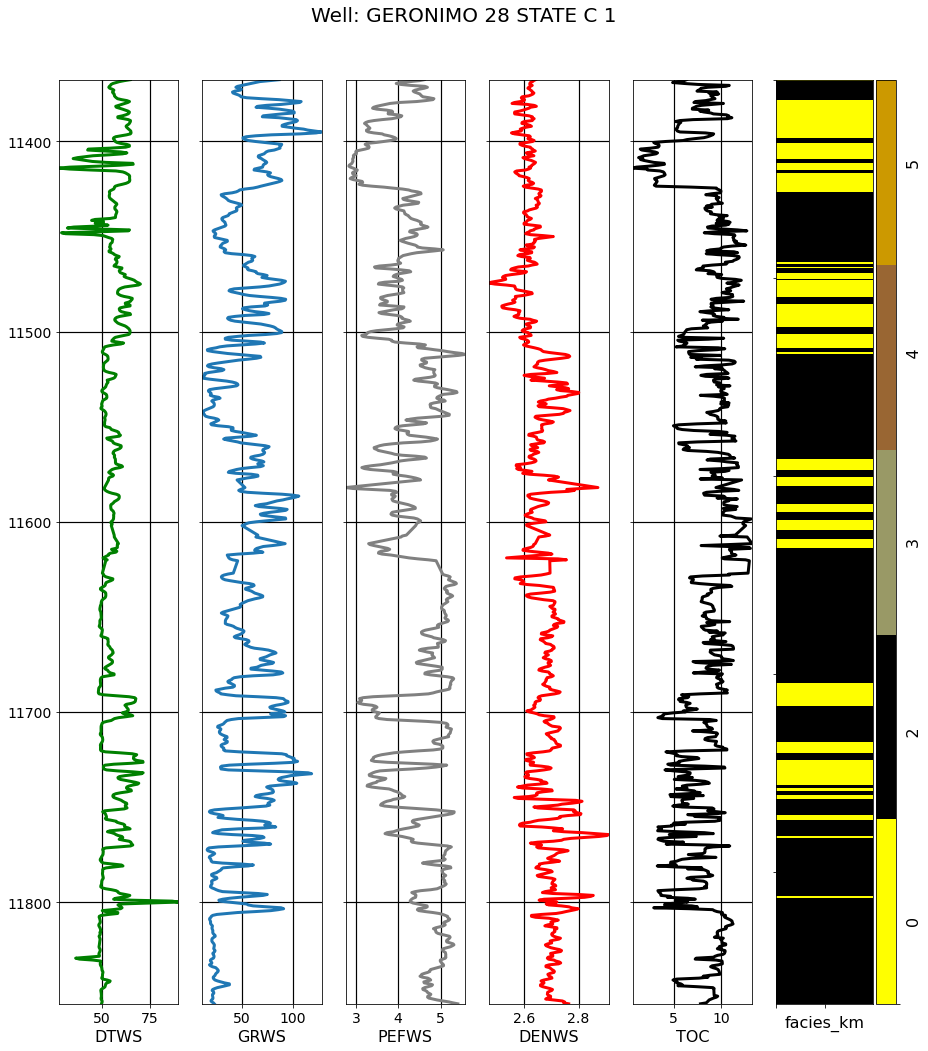

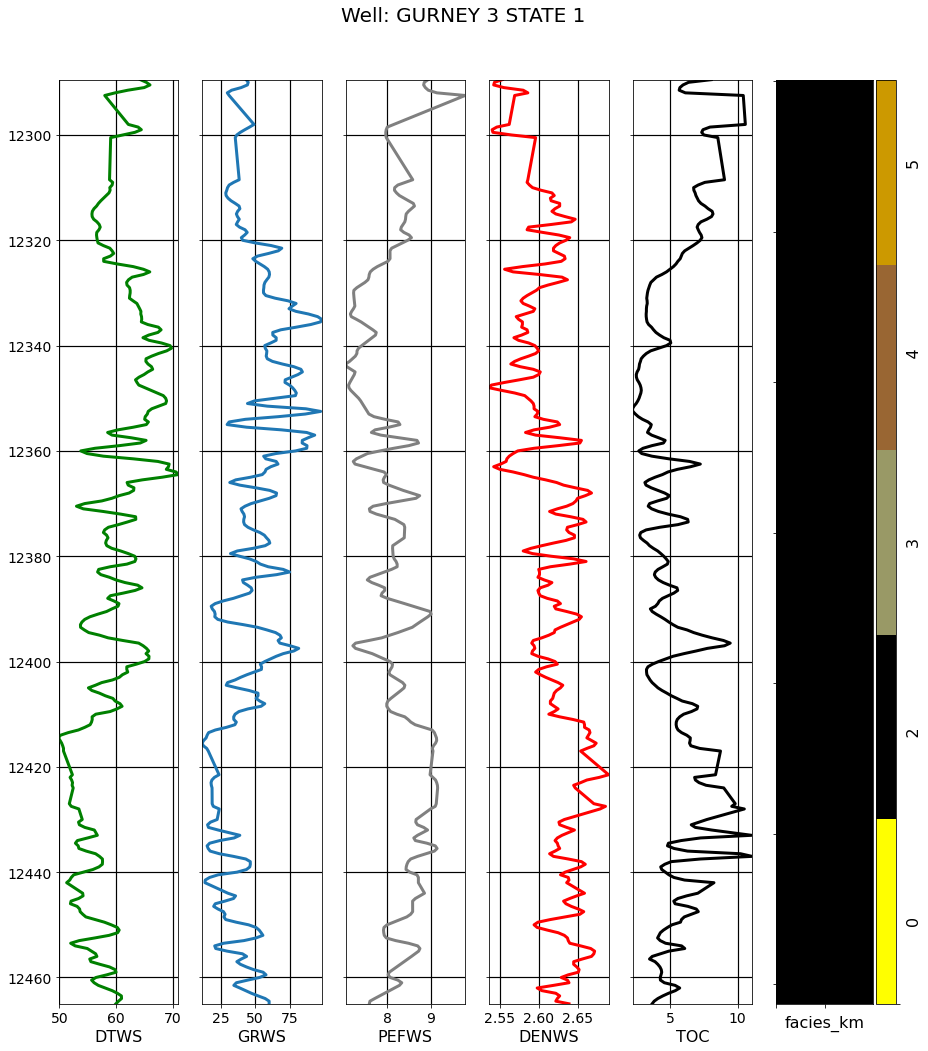

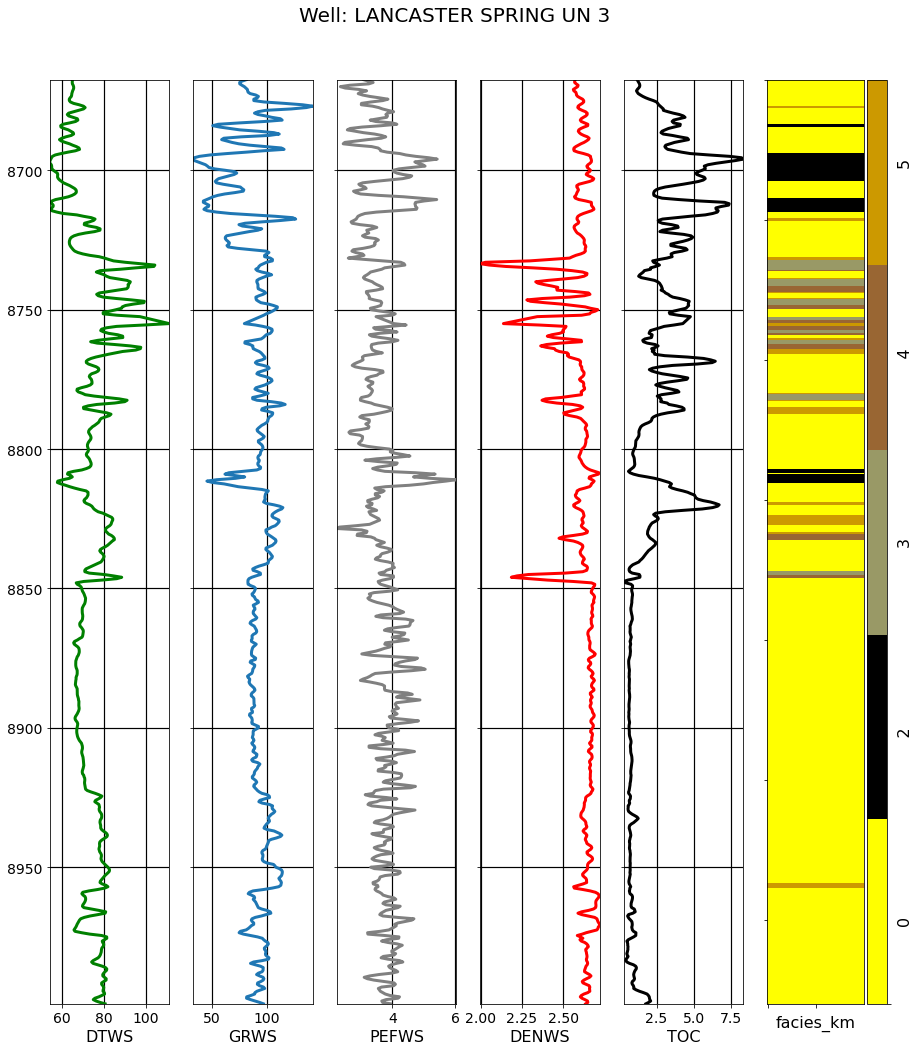

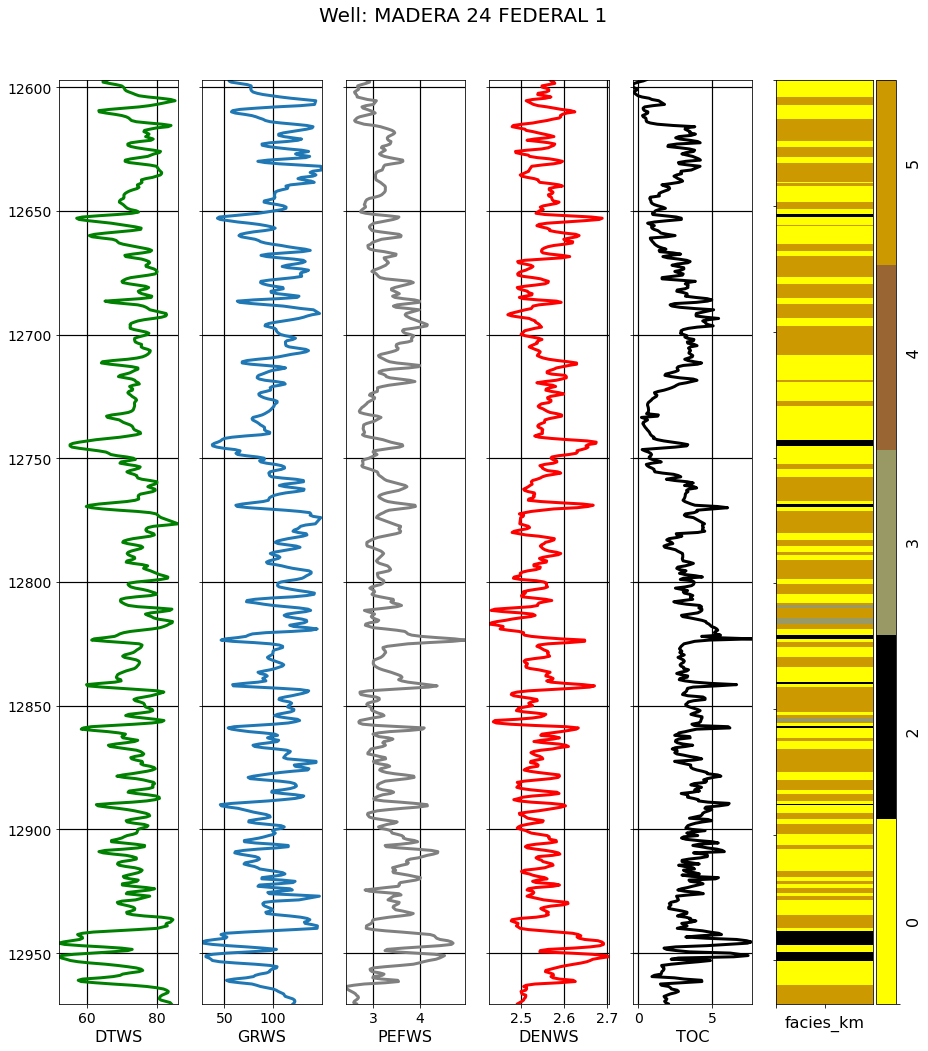

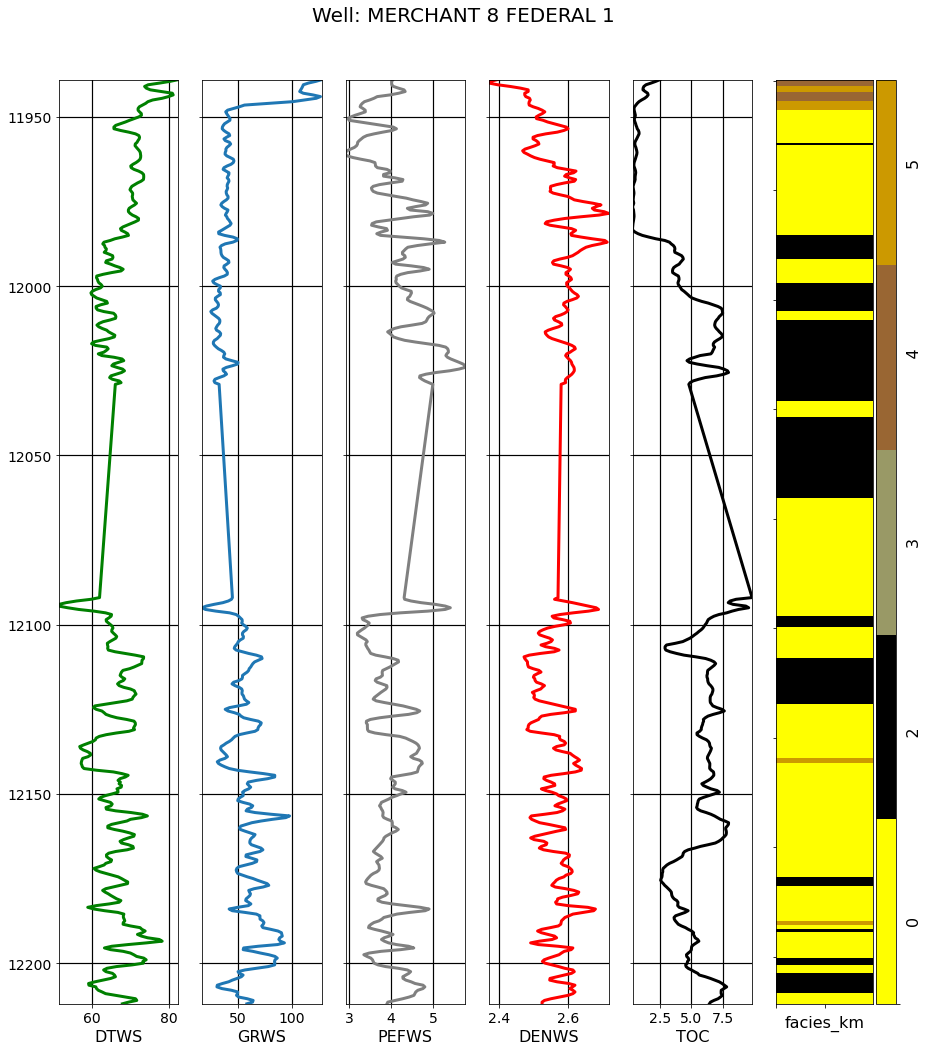

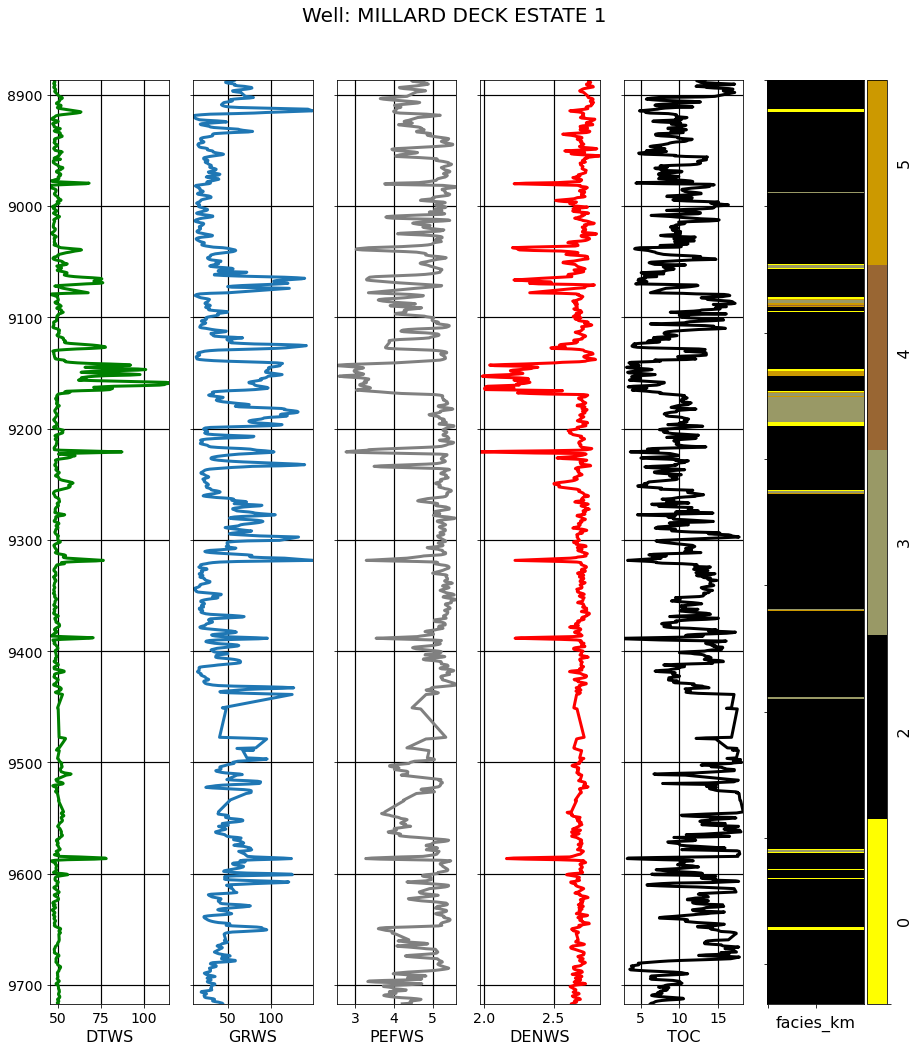

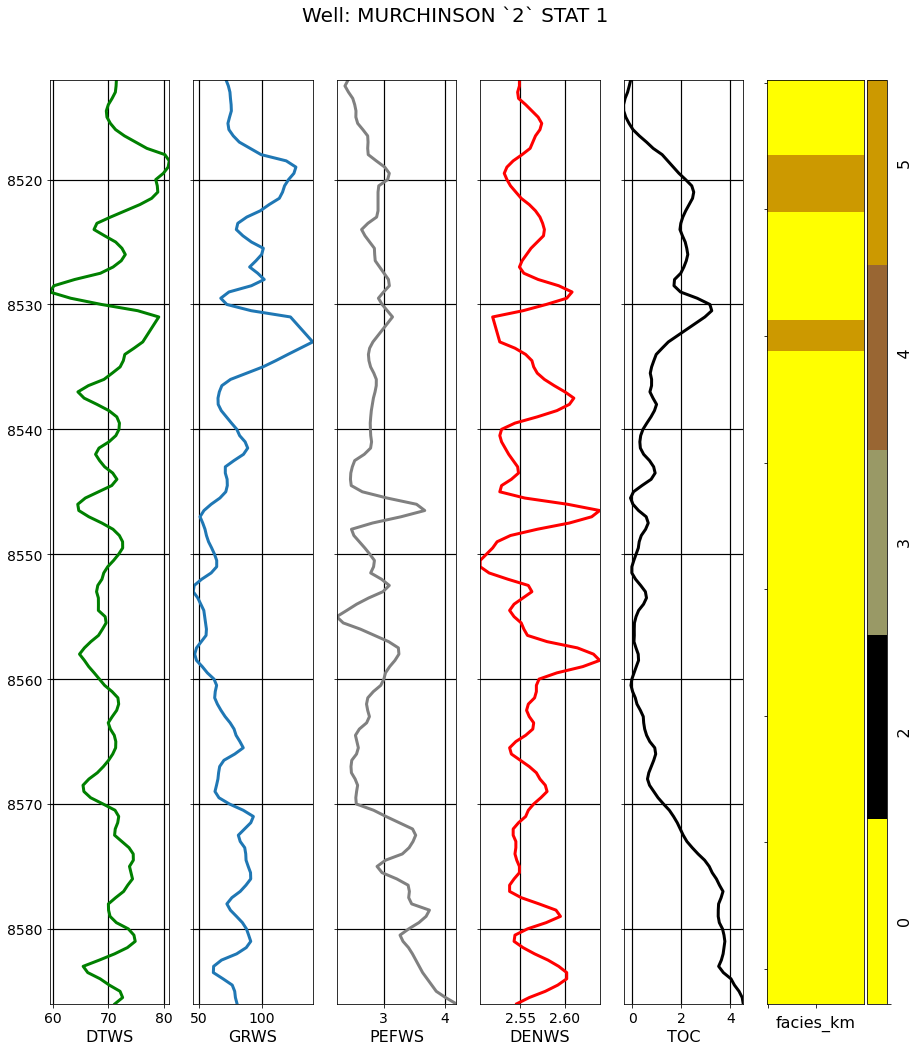

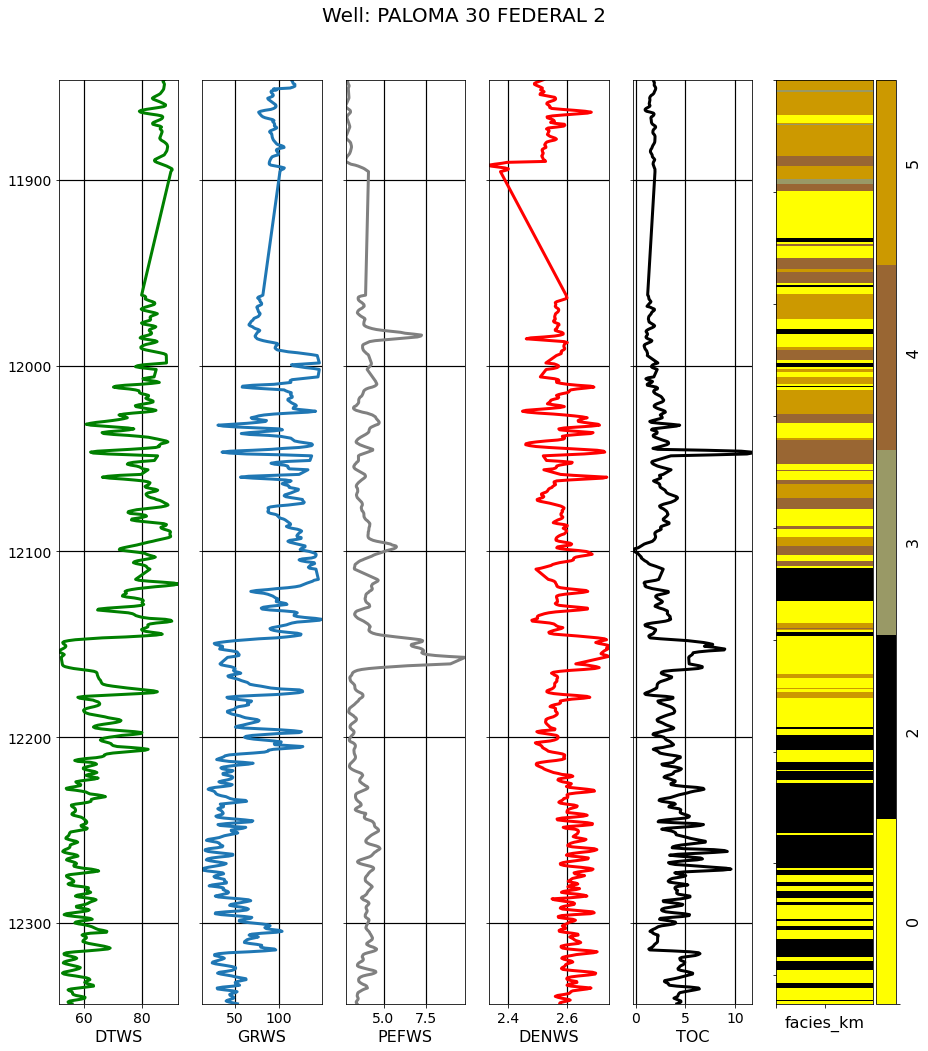

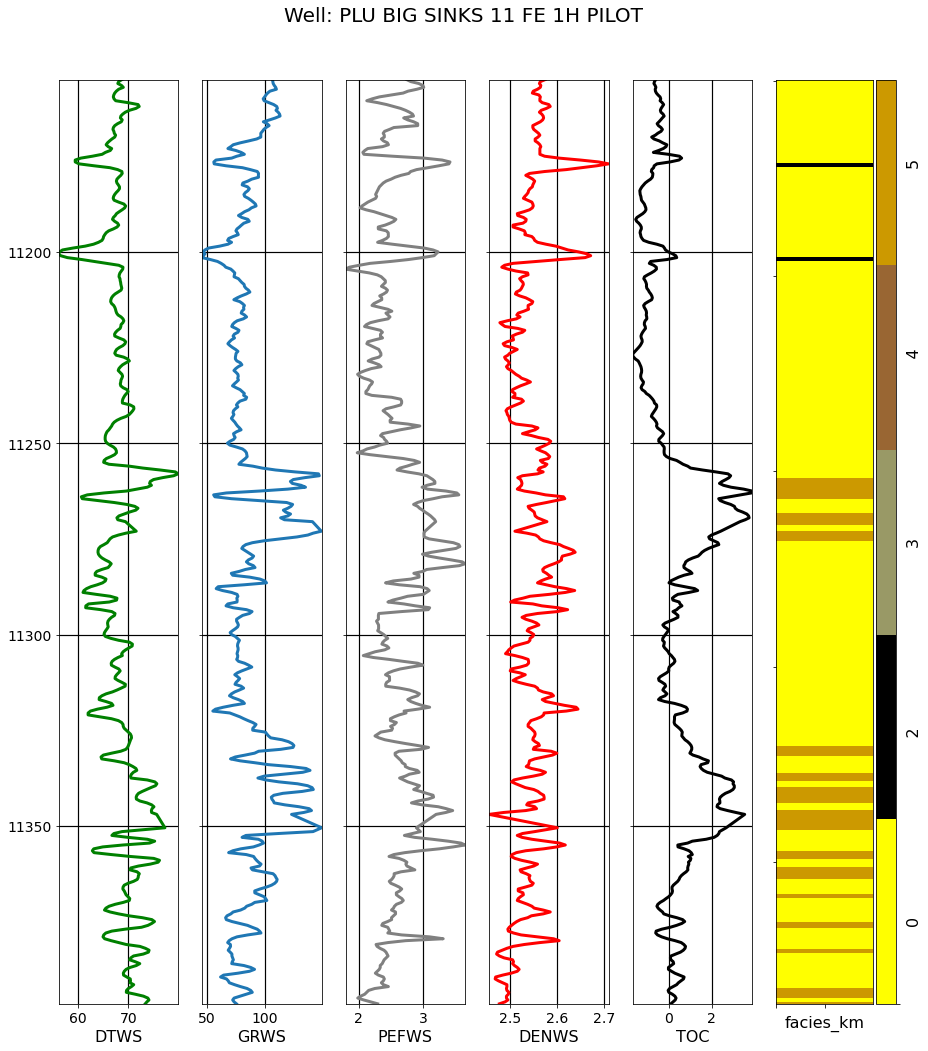

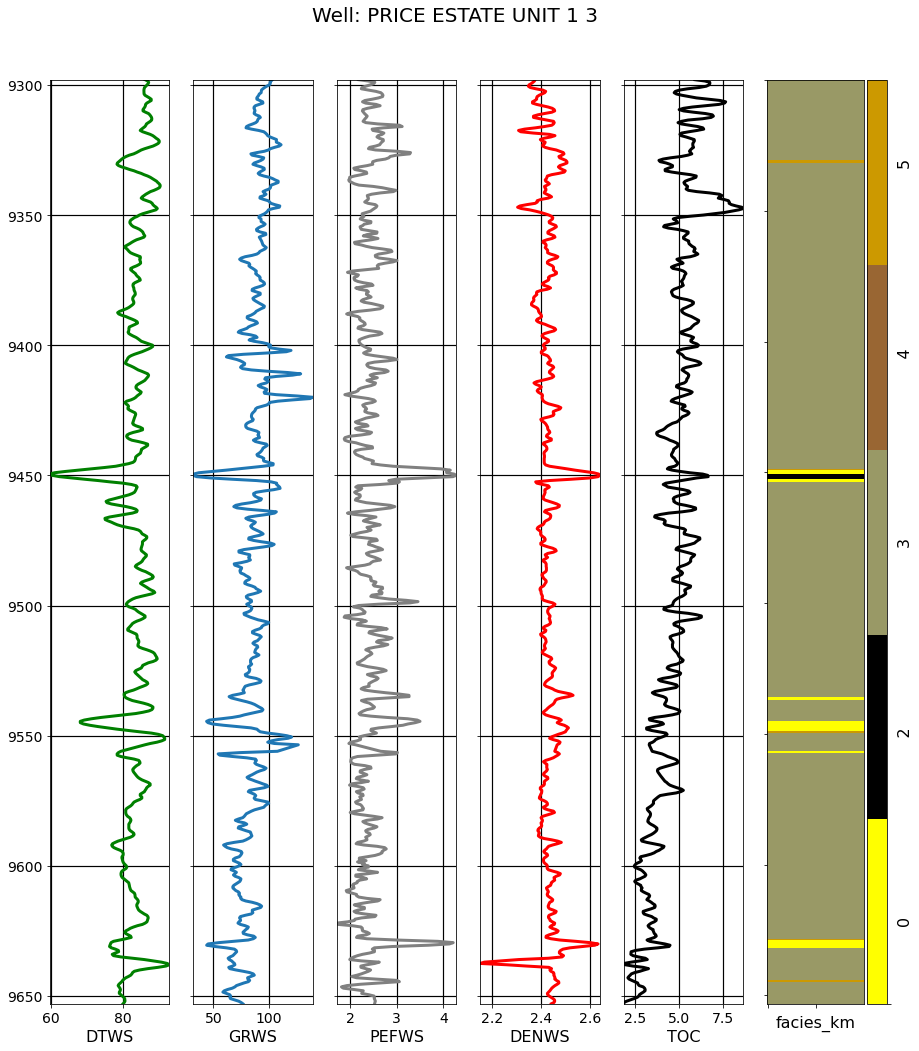

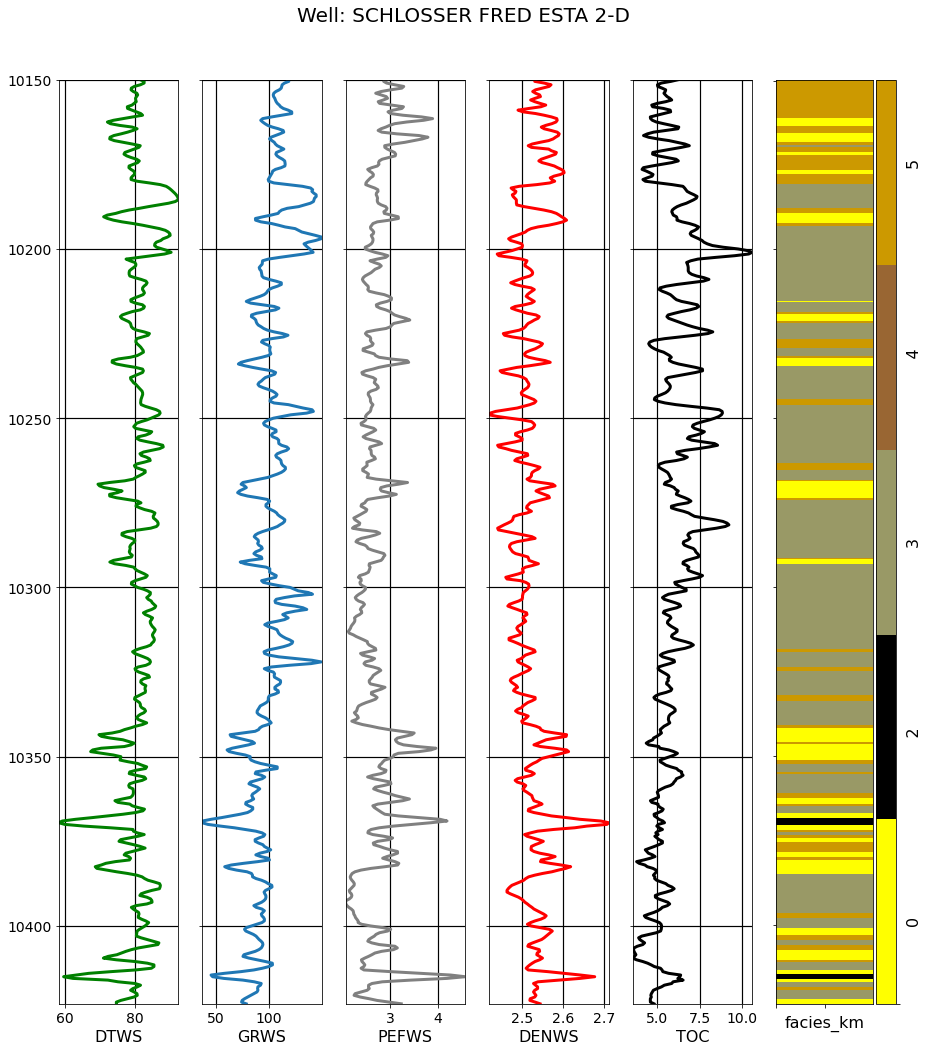

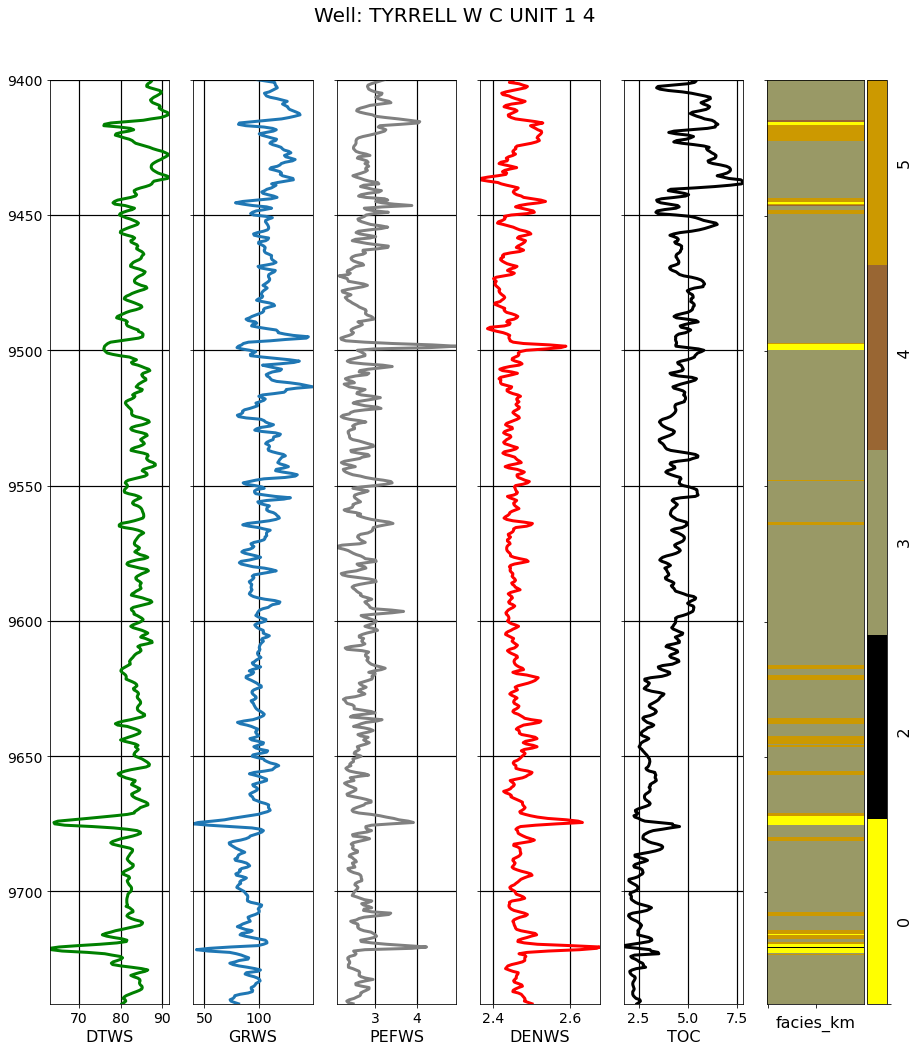

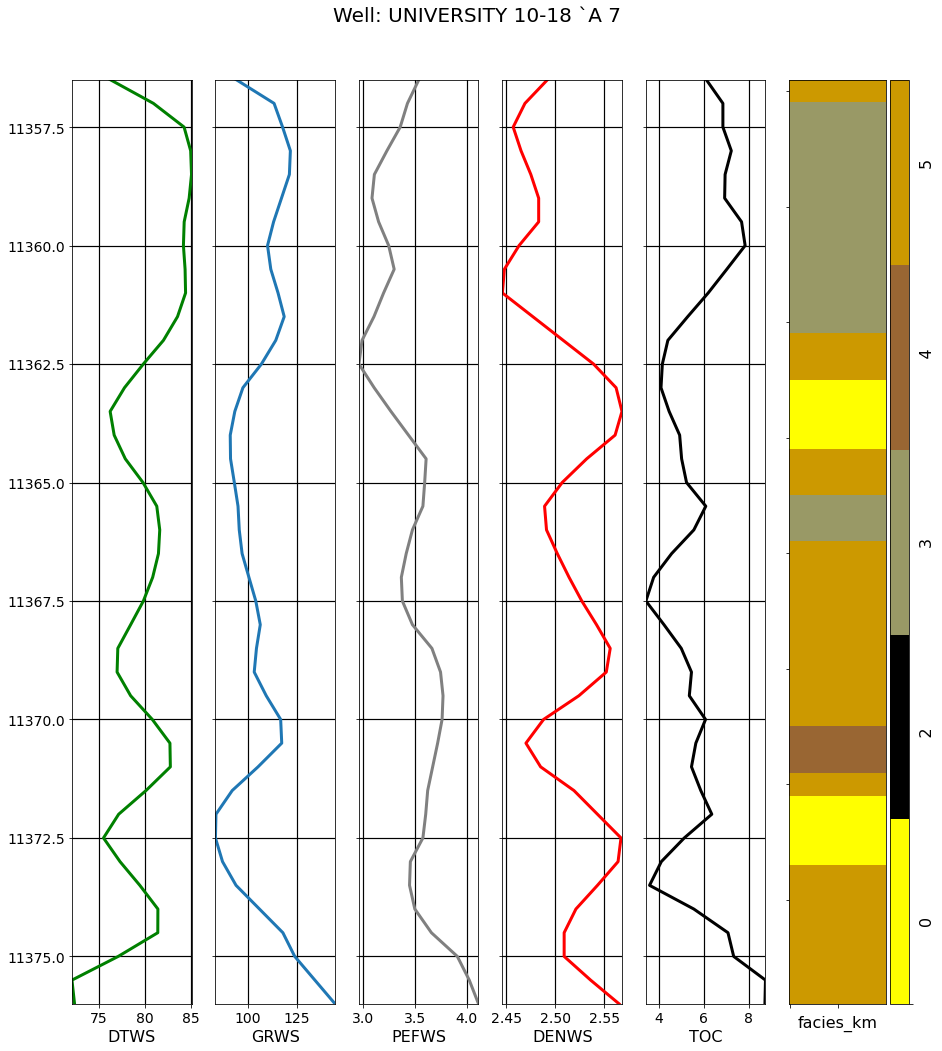

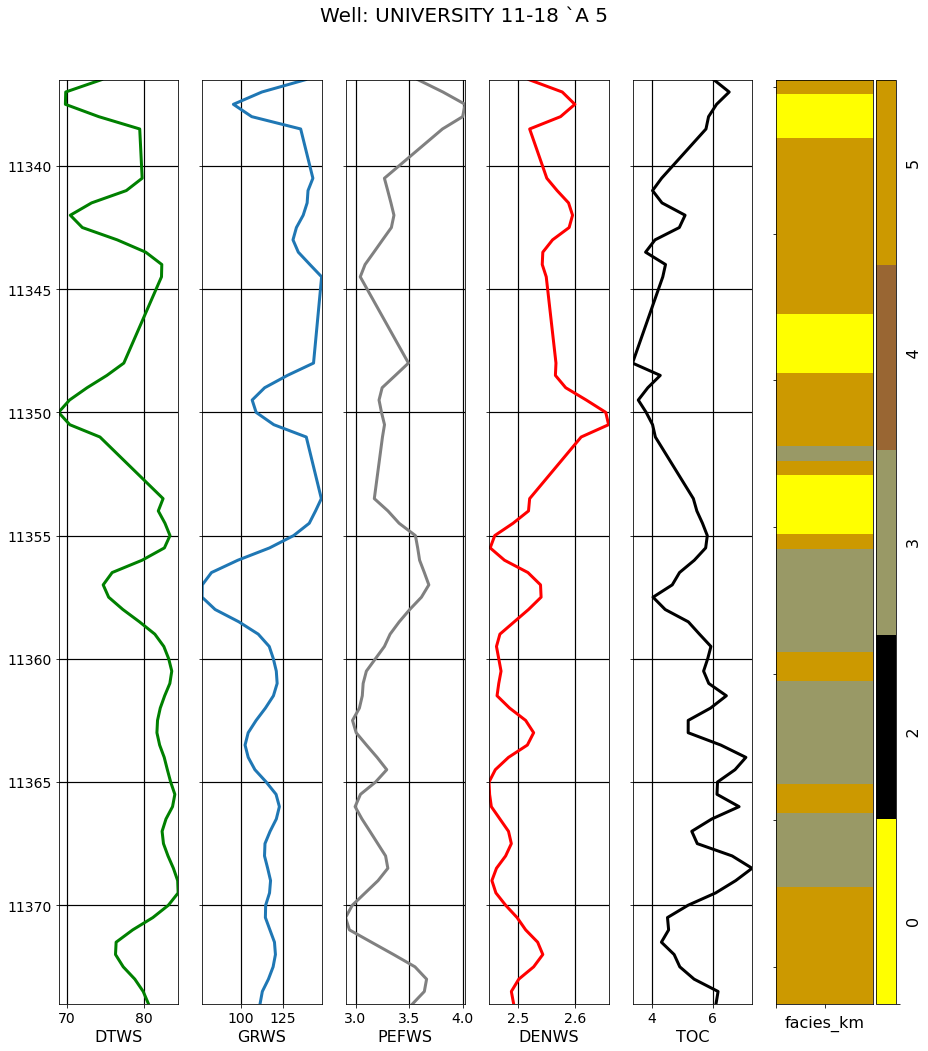

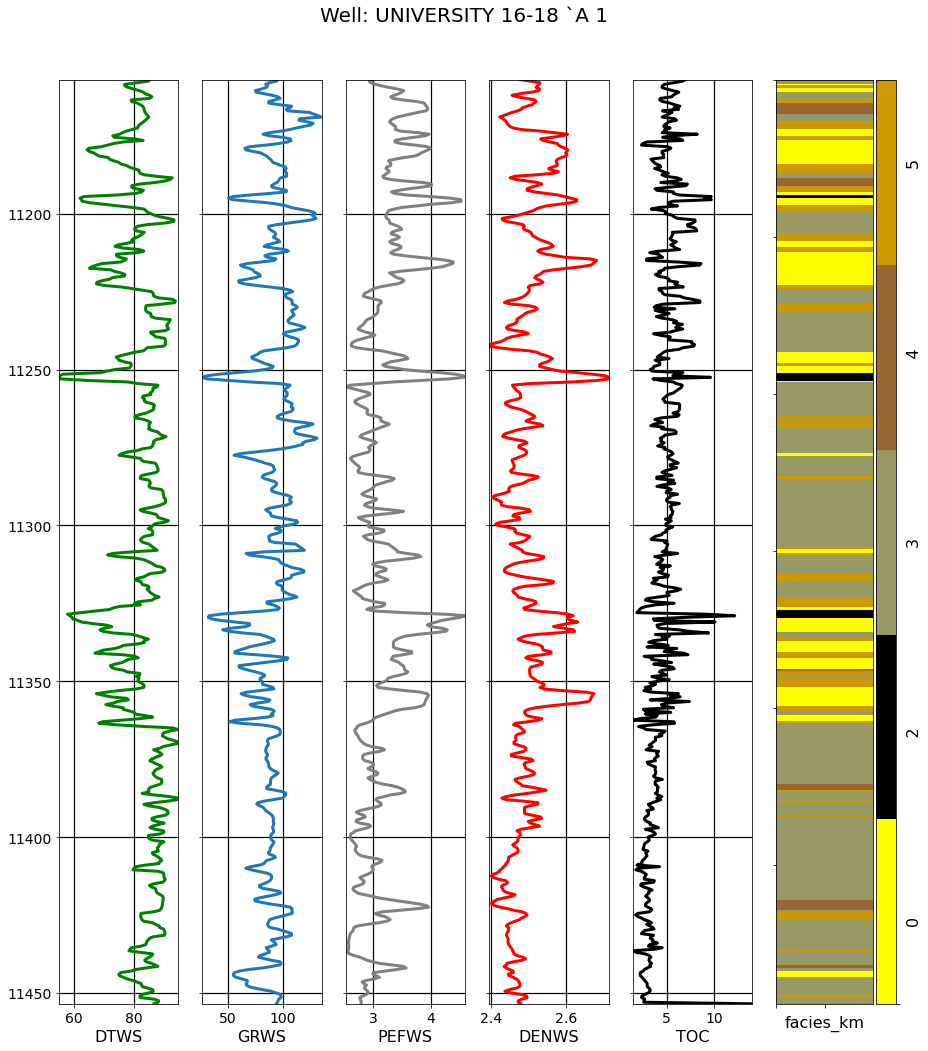

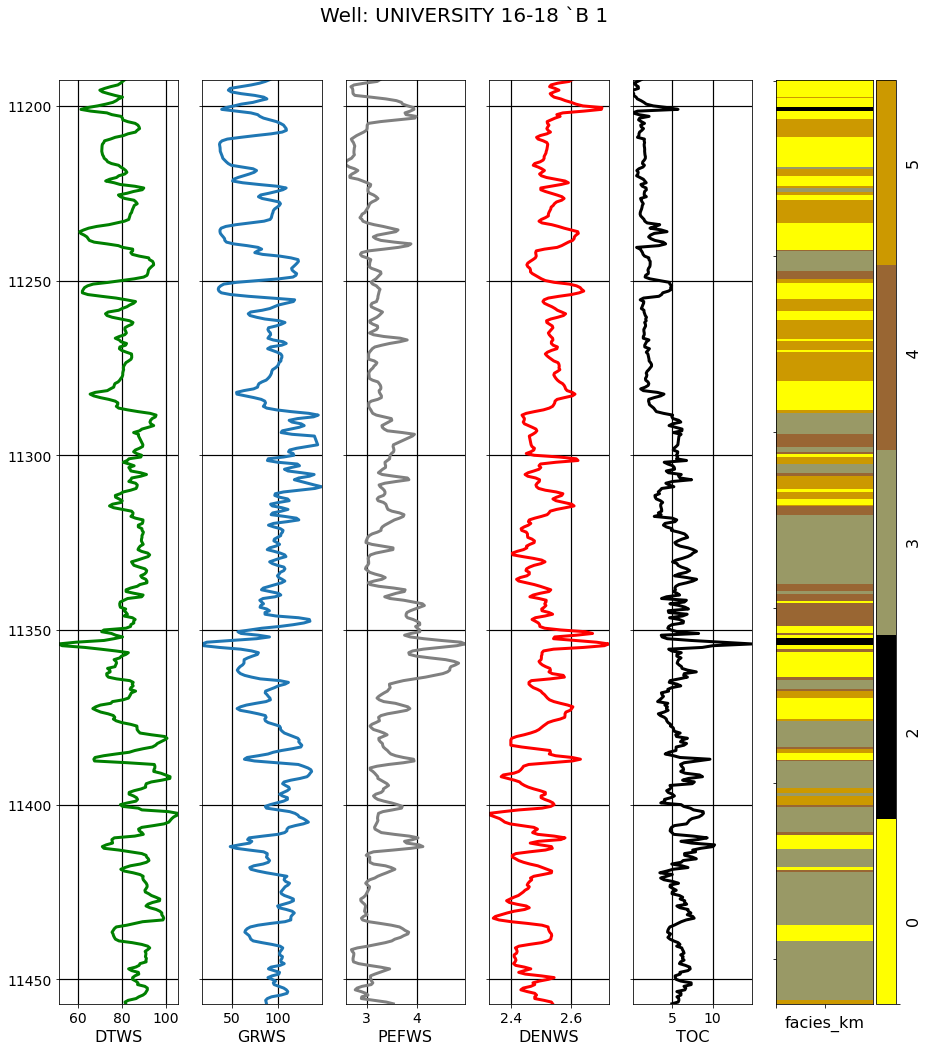

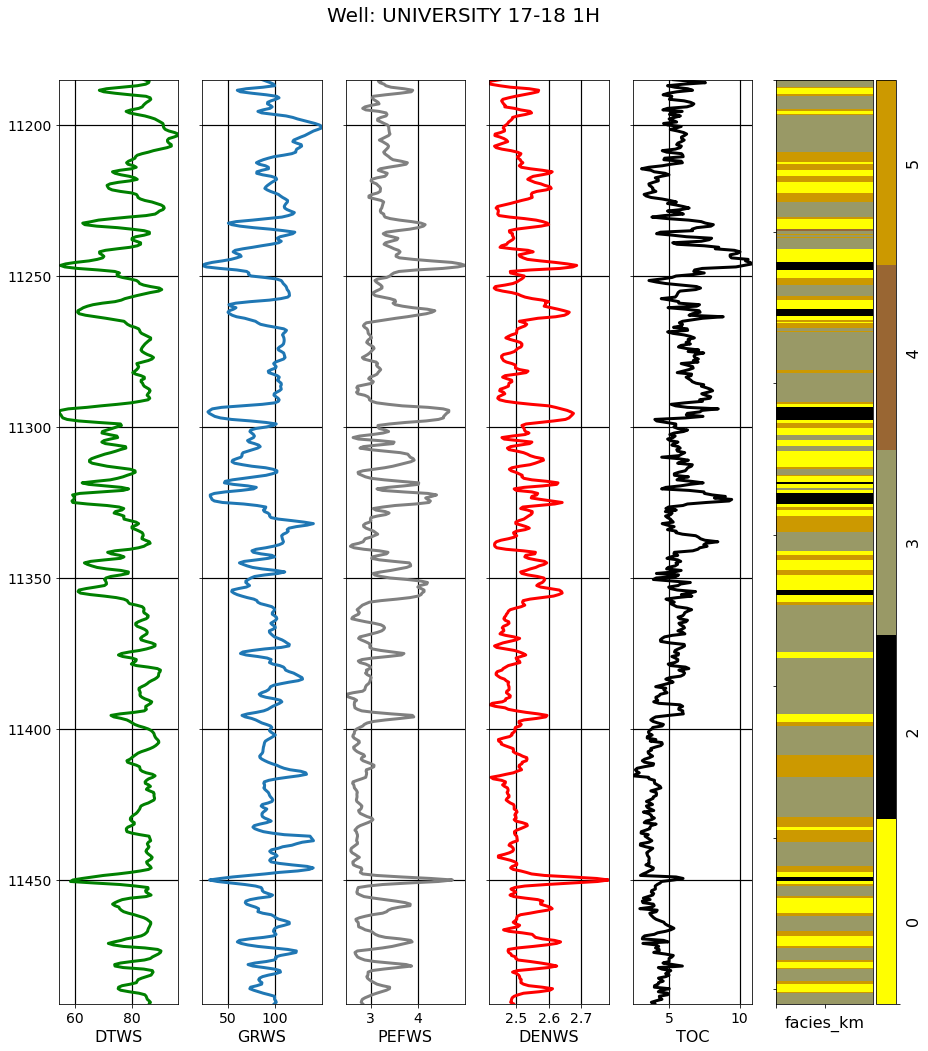

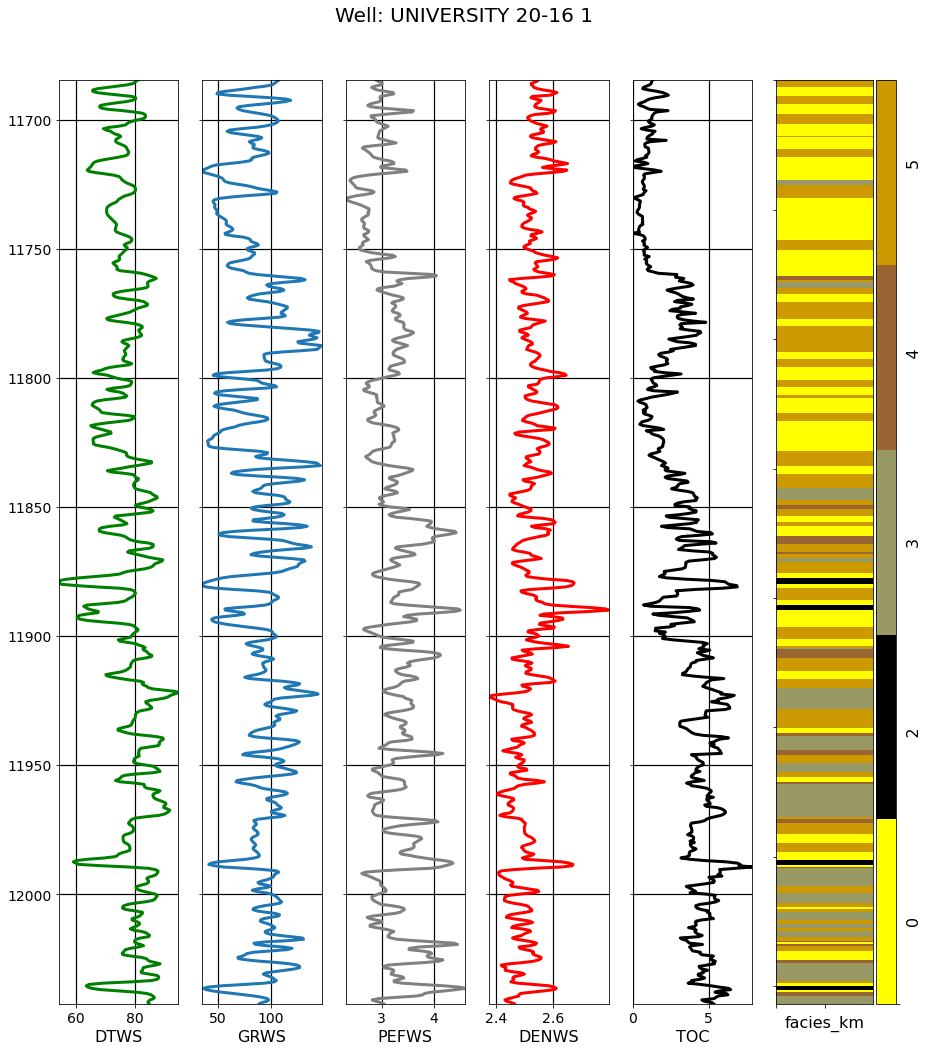

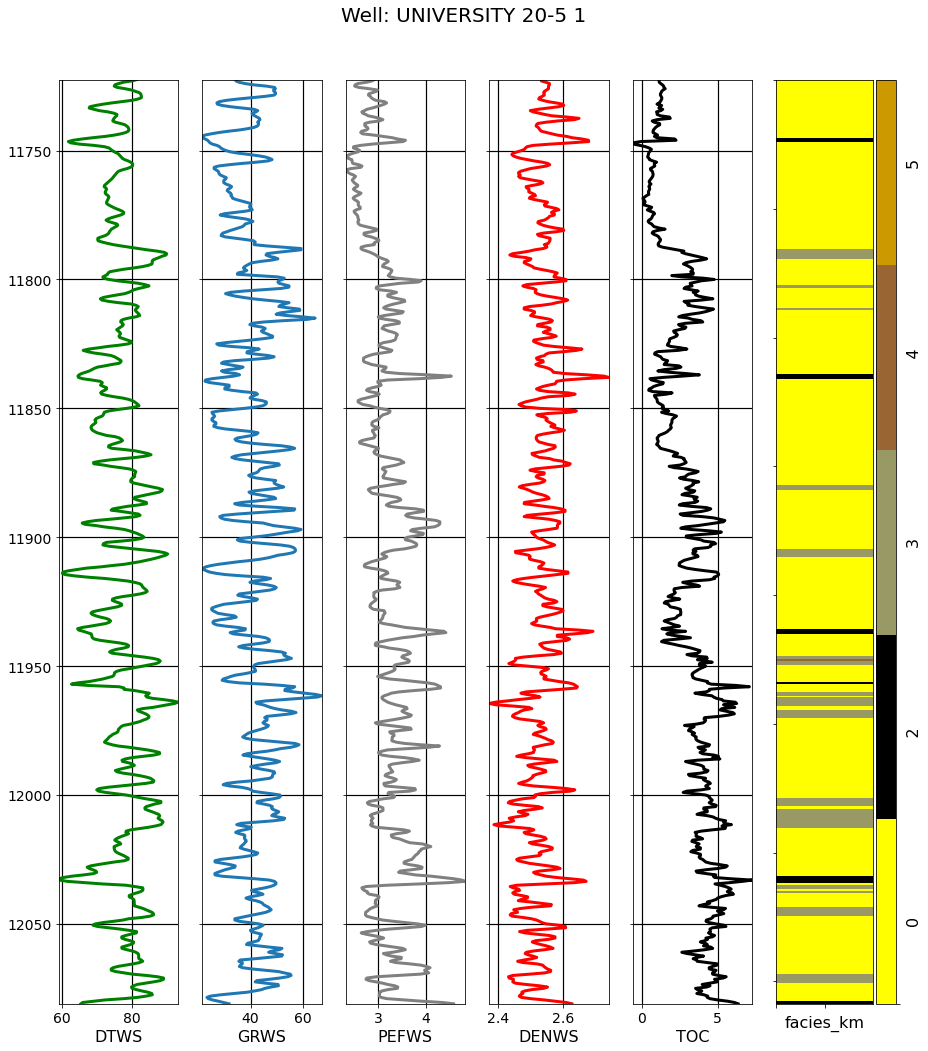

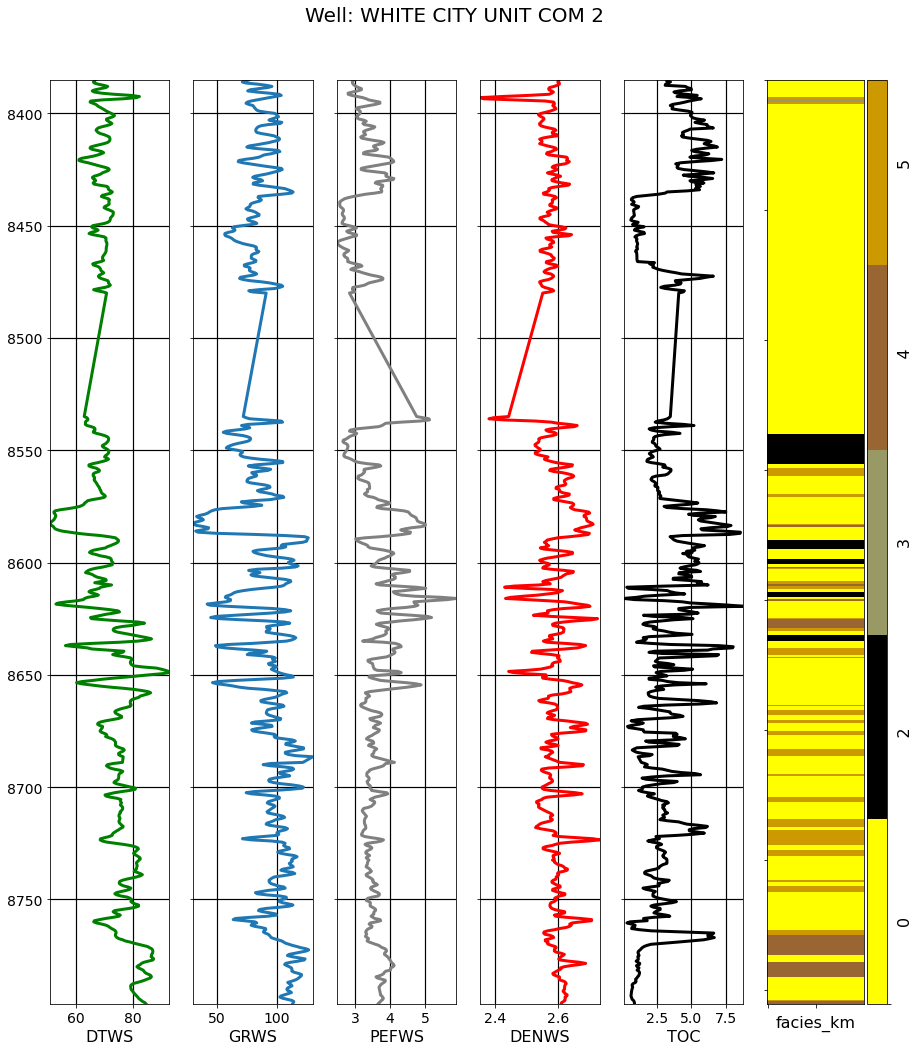

In [46]:
well_list=np.unique(data['WELL'])
for i in well_list:
    make_facies_log_plot(data, i, 'facies_km')